# Regresión
El objetivo es estimar el precio `price` de un diamante a partir de un conjunto de propiedades físicas del mismo:

| Variable | Descripción  | Valores |  
|-----|-------|-------|
|carat|peso del diamante| númerico |
|cut  |calidad del corte| Fair, Good, Very good, Premium, Ideal.|
|color| color | J(peor color) a D(mejor color)|
|clarity| medida de la claridad del diamante |(I1 (peor calidad), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (mejor claridad))|
|x|longitud en mm| númerico |
| y|anchura en mm| númerico |
| z| profundidad en mm| númerico |
| depth| porcentaje de profundidad total 2 * z / (x + y)| númerico |
| table|ancho de la punta del diamante relativa al punto más ancho.| númerico |

In [105]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from datetime import datetime

from sklearn.metrics import confusion_matrix

warnings.filterwarnings(action='once')

# 1. Carga, preparación y transformaciones de datos

In [2]:
data = pd.read_csv('./data/diamonds_train.csv',sep=',', decimal='.')
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.43,Very Good,E,SI2,59.9,57.0,671,4.88,4.94,2.94
1,1.15,Good,H,SI1,60.2,61.0,5005,6.74,6.84,4.09
2,0.52,Ideal,E,VS2,61.3,56.0,1621,5.17,5.21,3.18
3,0.32,Ideal,G,VVS2,61.7,57.0,730,4.41,4.44,2.73
4,1.00,Premium,D,SI1,61.4,58.0,5880,6.43,6.37,3.93


In [3]:
data.isnull().any()

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x          False
y          False
z          False
dtype: bool

In [4]:
# Transformacion de variables
corte = {'Fair': 1,'Good': 2, 'Very Good': 3, 'Premium':4, 'Ideal':5}
color = {'J':1,'I':2,'H':3,'G':4,'F':5,'E':6,'D':7}
claridad = {'I1':1,'SI2':2,'SI1':3,'VS2':4,'VS1':5,'VVS2':6,'VVS1':7,'IF':8}

data.cut = [corte[item] for item in data.cut] 
data.color = [color[item] for item in data.color]
data.clarity = [claridad[item] for item in data.clarity] 

In [5]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.43,3,6,2,59.9,57.0,671,4.88,4.94,2.94
1,1.15,2,3,3,60.2,61.0,5005,6.74,6.84,4.09
2,0.52,5,6,4,61.3,56.0,1621,5.17,5.21,3.18
3,0.32,5,4,6,61.7,57.0,730,4.41,4.44,2.73
4,1.00,4,7,3,61.4,58.0,5880,6.43,6.37,3.93


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,43152.0,0.799810,0.474396,0.2,0.40,0.70,1.04,5.01
cut,43152.0,3.897293,1.117454,1.0,3.00,4.00,5.00,5.00
color,43152.0,4.400932,1.704806,1.0,3.00,4.00,6.00,7.00
clarity,43152.0,4.043358,1.642435,1.0,3.00,4.00,5.00,8.00
depth,43152.0,61.752361,1.439128,43.0,61.00,61.80,62.50,79.00
table,43152.0,57.462706,2.229668,43.0,56.00,57.00,59.00,76.00
price,43152.0,3942.483384,3990.866274,326.0,954.00,2421.00,5335.00,18823.00
x,43152.0,5.735674,1.121841,0.0,4.72,5.70,6.54,10.74
y,43152.0,5.739552,1.149528,0.0,4.73,5.71,6.54,58.90
z,43152.0,3.541920,0.708278,0.0,2.91,3.53,4.04,31.80


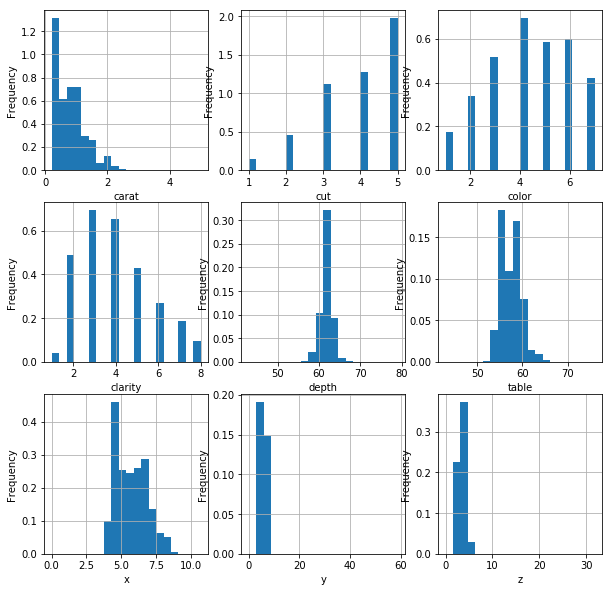

In [7]:
# Pintamos histogramas para cada clase

plt.figure(figsize=(10,10))
for i,feature in enumerate(data.columns.drop(['price'])):
    
    plt.subplot(3,3,i+1)
    data[feature].plot.hist(bins=20, density=1, grid = True)
    plt.xlabel(feature)

plt.show()


In [8]:
def scatter(var):
    data.plot(kind = 'scatter',x=var,y = 'price')
    plt.xlabel(var)
    plt.ylabel('price ($)')
    plt.show()
    

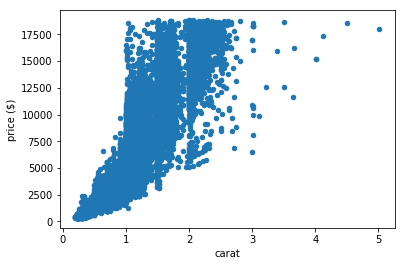

In [9]:
scatter('carat')

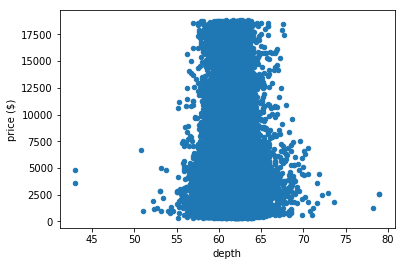

In [10]:
scatter('depth')

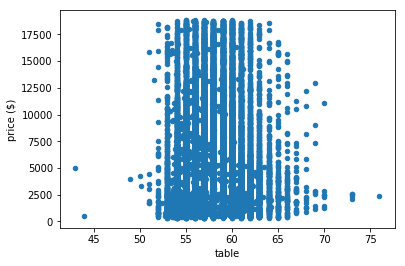

In [11]:
scatter('table')

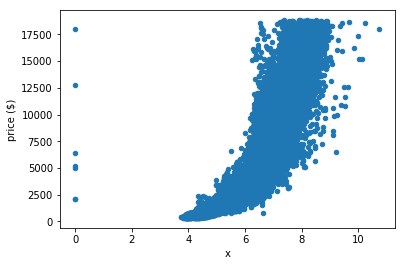

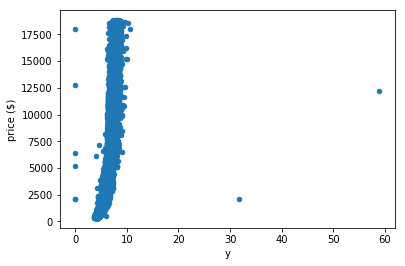

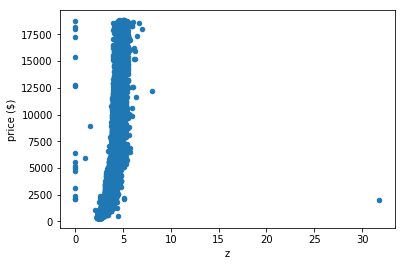

In [12]:
scatter('x')
scatter('y')
scatter('z')

Vemos que en `x`, `y` y `z` hay outliers. Los eliminamos.

In [13]:
print(data.shape)

#Elimino Outliers
x_Zero =  data['x'] != 0
y_Zero =  data['y'] != 0
z_Zero =  data['z'] != 0
y_mas =  data['y'] < 30
z_mas =  data['z'] < 15

data = data[x_Zero]
data = data[y_Zero]
data = data[z_Zero]
data = data[y_mas]
data = data[z_mas]

print(data.shape)


(43152, 10)
(43133, 10)


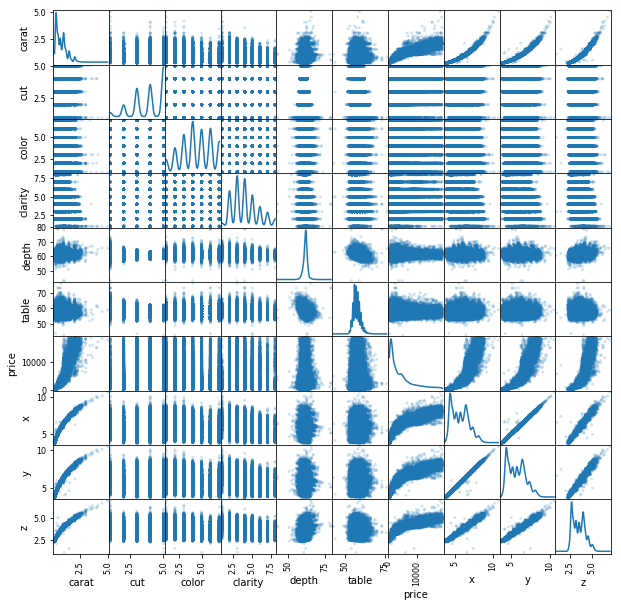

In [194]:
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(10, 10), diagonal = 'kde')
plt.show()

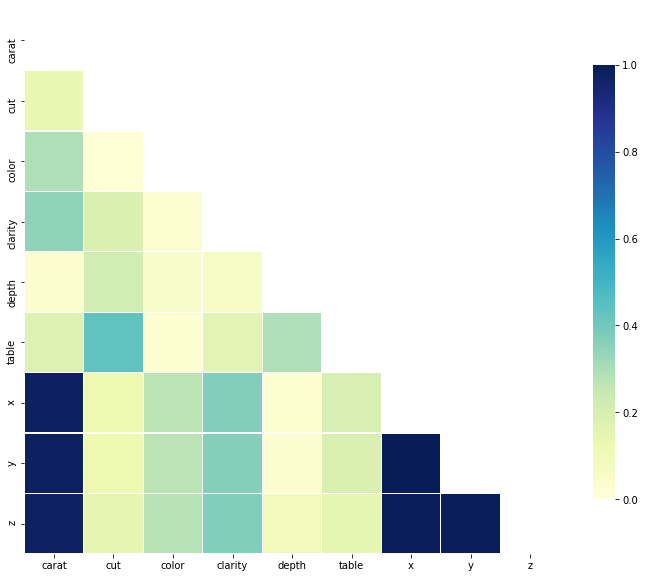

In [14]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [15]:
data.corr()

,carat,cut,color,clarity,depth,table,price,x,y,z
carat,1.000000,-0.135213,-0.294123,-0.350453,0.028005,0.181322,0.921715,0.977785,0.976868,0.976497
cut,-0.135213,1.000000,0.018719,0.189802,-0.219111,-0.433861,-0.052962,-0.126009,-0.125544,-0.152287
color,-0.294123,0.018719,1.000000,-0.025301,-0.047126,-0.024141,-0.175367,-0.273394,-0.273380,-0.277779
clarity,-0.350453,0.189802,-0.025301,1.000000,-0.067868,-0.161649,-0.144744,-0.369899,-0.364545,-0.373492
depth,0.028005,-0.219111,-0.047126,-0.067868,1.000000,-0.294812,-0.013057,-0.024974,-0.028177,0.097375
table,0.181322,-0.433861,-0.024141,-0.161649,-0.294812,1.000000,0.127254,0.195757,0.189524,0.155556
price,0.921715,-0.052962,-0.175367,-0.144744,-0.013057,0.127254,1.000000,0.887495,0.889149,0.882123
x,0.977785,-0.126009,-0.273394,-0.369899,-0.024974,0.195757,0.887495,1.000000,0.998610,0.991101
y,0.976868,-0.125544,-0.273380,-0.364545,-0.028177,0.189524,0.889149,0.998610,1.000000,0.990767
z,0.976497,-0.152287,-0.277779,-0.373492,0.097375,0.155556,0.882123,0.991101,0.990767,1.000000


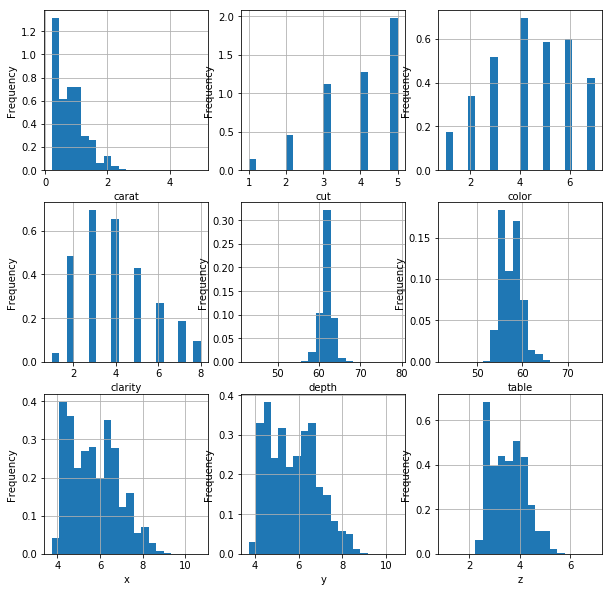

In [16]:
# Pintamos histogramas para cada clase

plt.figure(figsize=(10,10))
for i,feature in enumerate(data.columns.drop(['price'])):
    
    plt.subplot(3,3,i+1)
    data[feature].plot.hist(bins=20, density=1, grid = True)
    plt.xlabel(feature)

plt.show()


Parece que los quilates (peso) están muy correlados con las dimensiones `x` `y` `z` y estas a su vez entre ellas, así que decido eliminar las dimensiones.


In [17]:
data = data.drop(["x", "y","z"], axis=1)

In [18]:
data.head()

,carat,cut,color,clarity,depth,table,price
0,0.43,3,6,2,59.9,57.0,671
1,1.15,2,3,3,60.2,61.0,5005
2,0.52,5,6,4,61.3,56.0,1621
3,0.32,5,4,6,61.7,57.0,730
4,1.00,4,7,3,61.4,58.0,5880


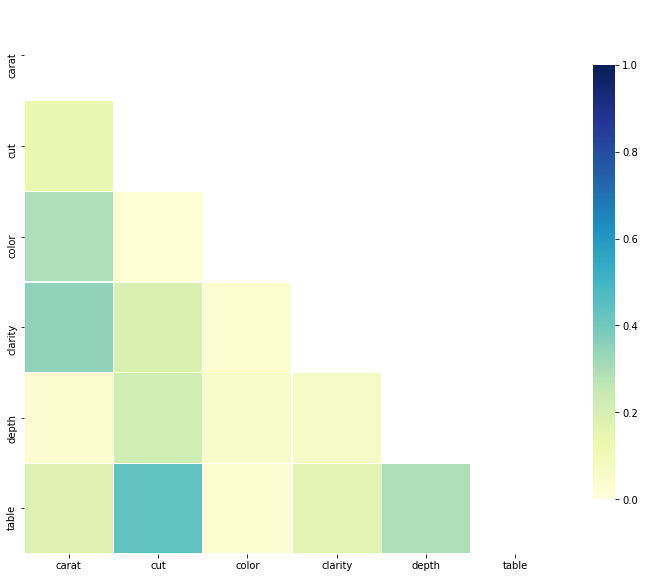

In [19]:

# Compute the correlation matrix
corr = np.abs(data.drop(['price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [20]:
corr

,carat,cut,color,clarity,depth,table
carat,1.000000,0.135213,0.294123,0.350453,0.028005,0.181322
cut,0.135213,1.000000,0.018719,0.189802,0.219111,0.433861
color,0.294123,0.018719,1.000000,0.025301,0.047126,0.024141
clarity,0.350453,0.189802,0.025301,1.000000,0.067868,0.161649
depth,0.028005,0.219111,0.047126,0.067868,1.000000,0.294812
table,0.181322,0.433861,0.024141,0.161649,0.294812,1.000000


Ya no parece haber ninguna correlación clara entre las variables, con lo que doy la preparación de datos por terminada.

# 2. Creamos conjunto de Test

Después de preparar los datos separamos un conjunto de test para realizar después la comprobación de los modelos elegidos.


In [21]:
from sklearn.model_selection import train_test_split

# preparamos los datos
features = data.columns.drop(['price'])
X = data[features].values
y = data['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)

Datos train:  (34506, 6)
Datos test:   (8627, 6)


Y lo escalamos:

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_S = scaler.transform(X_train)
X_test_S = scaler.transform(X_test)

## 3. Pruebas de distintos algoritmos de ML
Una vez tenemos los conjuntos de Train y Test, voy a ir probando distintos algoritmos para ver como se comportan con nuestros datos.

Para ello, el procedimiento va a ser el siguiente:
- Elegimos un modelo.
- Alimentamos un GridSearch con el modelo y los datos, asi como el parametro libre sobre el que queremos realizar la optimización.
- Representamos la evolución de ese parametro libre en el GridSearch para encontrar el que resulta más optimo. Si podemos optimizar el modelo, estos calculos se pueden realizar en la misma celda o en la siguientes, según sea necesario visualizar mejor el resultado o el tiempo de computacion.
- Los resultados del modelo, así como los parametros libres elegidos se almacenan en un dataframe `resultadosModelo` que nos permitirán realizar la eleccion del modelo al final.

A modo informativo, antes de comenzar el `GridSearch` se inicia un cronometro, con lo que podemos hacernos una idea de cuanto tiempo nos ha costado optimizar el modelo. Este valor se almacena también en el dataframe de `resultadosModelo`. También añado la matriz de confusión y las metricas.

In [130]:
columns = ['Modelo', 'parametros-optimos', 'MSE_train', 'MSE_test','r2_train', 'r2_test']

resultadosModelo = pd.DataFrame(columns=columns)

def add_row(df, row):
    df.loc[-1] = row
    df.index = df.index + 1  
    return df.sort_index()

### 3.1 Regresión lineal

In [85]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [86]:
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train_S, y_train)

y_pred_train = lr.predict(X_train_S)
y_pred_test = lr.predict(X_test_S)

mseTrain = mean_squared_error(y_train, y_pred_train)
mseTest = mean_squared_error(y_test, y_pred_test)
r2train = lr.score(X_train_S, y_train)
r2test = lr.score(X_test_S, y_test)

resultado = ["Modelo Lineal", "grado-1", mseTrain, mseTest, r2train, r2test]
add_row(resultadosModelo, resultado)

print('MSE Modelo Lineal - grado 1 (train): %0.7g' % mseTrain)
print('MSE Modelo Lineal - grado 1 (test) : %0.7g' % mseTest)
print("R^2 (train): {:.4f}".format(r2train))
print("R^2 (test): {:.4f}".format(r2test))

MSE Modelo Lineal - grado 1 (train): 1508823
MSE Modelo Lineal - grado 1 (test) : 1556773
R^2 (train): 0.9059
R^2 (test): 0.8991


### 3.2 Ridge
Probamos con distintos valores de alpha para encontrar el optimo.

(Se ve como la variable alpha_vector tiene asignaciones sucesivas para cada iteración que he realizado)

best mean cross-validation score: -1510104.472
best parameters: {'alpha': 1.4195547660501011}


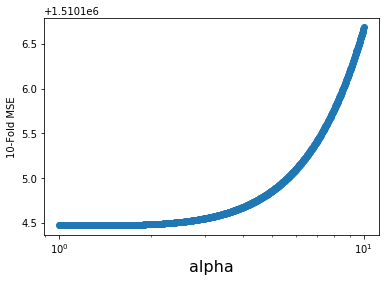

In [87]:
from sklearn.linear_model import Ridge


alpha_vector = np.logspace(-5,10,100)   # Primera aproximación
                                        # Best parameters: {'alpha': 1.4174741629268048}
alpha_vector = np.logspace(0,5,100)     # Centramos donde es el valor optimo
                                        # Best parameters: {'alpha': 1.4174741629268053}
alpha_vector = np.logspace(0,5,1000)    # En ese segmento hacemos aún más divisiones 
                                        # Best parameters: {'alpha': 1.413025990599534}
    
alpha_vector = np.logspace(0,1,100)     #best parameters: {'alpha': 1.4174741629268053}

alpha_vector = np.logspace(0,1,1000)    # best parameters: {'alpha': 1.4195547660501011}


param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10, n_jobs=8)
grid.fit(X_train_S, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((0, 1))
plt.show()

Con este alpha calculado entrenamos el modelo.

In [88]:
alpha_optimo = grid.best_params_['alpha']
print(grid.best_params_)
ridge = Ridge(alpha = alpha_optimo).fit(X_train_S, y_train)

{'alpha': 1.4195547660501011}


Y realizamos las predicciones:

In [89]:
y_pred_train = ridge.predict(X_train_S)
y_pred_test = ridge.predict(X_test_S)

mseTrain = mean_squared_error(y_train, y_pred_train)
mseTest = mean_squared_error(y_test, y_pred_test)

r2train = ridge.score(X_train_S, y_train)
r2test = ridge.score(X_test_S, y_test)

In [90]:
resultado = ["Ridge", grid.best_params_, mseTrain, mseTest, r2train, r2test]
add_row(resultadosModelo, resultado)

print('MSE Ridge (train): %0.7g' % mseTrain)
print('MSE Ridge (test) : %0.7g' % mseTest)
print("R^2 (train): {:.4f}".format(r2train))
print("R^2 (test): {:.4f}".format(r2test))

MSE Ridge (train): 1508823
MSE Ridge (test) : 1556762
R^2 (train): 0.9059
R^2 (test): 0.8991


### 3.3 Lasso

In [91]:
from sklearn.linear_model import Lasso

best mean cross-validation score: -1510104.533
best parameters: {'alpha': 0.00038652211626312617}


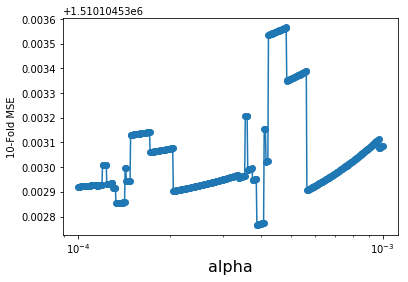

In [92]:
alpha_vector = np.logspace(-1,10,50)  # best parameters: {'alpha': 0.1}
alpha_vector = np.logspace(-4,5,50)   # best parameters: {'alpha': 0.00023299518105153718}
alpha_vector = np.logspace(-5,1,50)   # best parameters: {'alpha': 0.0003906939937054617}
alpha_vector = np.logspace(-7,-1,50)  # best parameters: {'alpha': 1.5998587196060572e-05}

alpha_vector = np.logspace(-6,-3,50)  # best parameters: {'alpha': 0.00013894954943731373}
alpha_vector = np.logspace(-4,-3,50)  # best parameters: {'alpha': 0.0003906939937054617}
alpha_vector = np.logspace(-4,-3,500)  # best parameters: {'alpha': 0.00038652211626312617}

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10, n_jobs=-1)
grid.fit(X_train_S, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

In [93]:
alpha_optimo = grid.best_params_['alpha']
print(grid.best_params_)
lasso = Lasso(alpha = alpha_optimo).fit(X_train_S, y_train)

{'alpha': 0.00038652211626312617}


In [94]:
y_pred_train = lasso.predict(X_train_S)
y_pred_test = lasso.predict(X_test_S)

mseTrain = mean_squared_error(y_train, y_pred_train)
mseTest = mean_squared_error(y_test, y_pred_test)

r2train = lasso.score(X_train_S, y_train)
r2test = lasso.score(X_test_S, y_test)

In [95]:
resultado = ["Lasso", grid.best_params_, mseTrain, mseTest, r2train, r2test]
add_row(resultadosModelo, resultado)

print('MSE Ridge (train): %0.7g' % mseTrain)
print('MSE Ridge (test) : %0.7g' % mseTest)
print("R^2 (train): {:.4f}".format(r2train))
print("R^2 (test): {:.4f}".format(r2test))

MSE Ridge (train): 1508823
MSE Ridge (test) : 1556773
R^2 (train): 0.9059
R^2 (test): 0.8991


### 3.4 Decision Tree

best mean cross-validation score: -386789.731
best parameters: {'max_depth': 11.333333333333332}


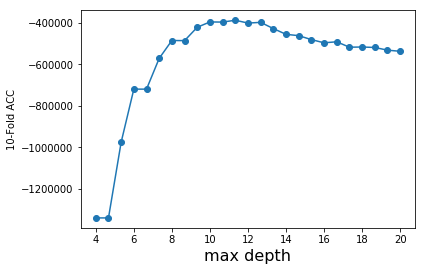

In [96]:
from sklearn.tree import DecisionTreeRegressor

max_depth = np.linspace(1,15,25)
max_depth = np.linspace(4,20,25)
param_grid = {'max_depth': max_depth}

grid = GridSearchCV(DecisionTreeRegressor(), 
                    scoring = 'neg_mean_squared_error', 
                    param_grid = param_grid, 
                    cv = 10,
                    n_jobs=-1)

grid.fit(X_train_S, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(max_depth,scores,'-o')
plt.xlabel('max depth', fontsize=16)
plt.ylabel('10-Fold ACC')
plt.show()

La profundidad máxima es 11, pero vemos que entre 10 y 14 es bastante estable. Voy a realizar distintos modelos con cada una de las profundidades

In [97]:
max_depth_opt = grid.best_params_['max_depth']
depth = int(max_depth_opt)
rangoDT = range (depth-2,depth+3)

In [100]:
for i in rangoDT:
    dtr = DecisionTreeRegressor(random_state = 0, max_depth = i).fit(X_train_S,y_train)

    ytrainDTR = dtr.predict(X_train_S)
    ytestDTR  = dtr.predict(X_test_S)
    
    mseTrain = mean_squared_error(y_train,ytrainDTR)
    mseTest = mean_squared_error(y_test,ytestDTR)
    
    r2train = dtr.score(X_train_S, y_train)
    r2test = dtr.score(X_test_S, y_test)
    
    parametros_optimos = {"max_depth":i}
    
    resultado = ["Decision Tree Regressor", parametros_optimos, mseTrain, mseTest, r2train, r2test]
    add_row(resultadosModelo, resultado)
    

### 3.5 Random Forest

best mean cross-validation score: 0.979
best parameters: {'max_depth': 18}


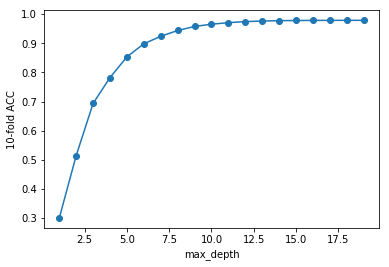

In [108]:
from sklearn.ensemble import RandomForestRegressor

maxDepth = range(1,20)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, 
                                           n_estimators=200, 
                                           max_features='sqrt'), 
                                           param_grid=tuned_parameters,
                                           cv=10,
                                           n_jobs=-1)
grid.fit(X_train_S, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Vemos que la profundidad maxima que proporciona el GridSearch es 18, pero que desde 9 es ya estable. 

Como en el caso anterior, voy a generar modelos con un rango de profundidades máximas, para ver cual se comporta mejor en cuanto a overfitting y prevenir el sobreentrenamiento.

In [131]:
rangoRF = range (9,20)

In [132]:
for i in rangoRF:
    
    tuned_parameters = {'max_depth': i}
    rfr = RandomForestRegressor(random_state=0, 
                                n_estimators=200, 
                               max_features='sqrt',
                               max_depth = i).fit(X_train_S,y_train)

    ytrainRFR = rfr.predict(X_train_S)
    ytestRFR  = rfr.predict(X_test_S)
    
    mseTrain = mean_squared_error(y_train,ytrainRFR)
    mseTest = mean_squared_error(y_test,ytestRFR)
    
    r2train = rfr.score(X_train_S, y_train)
    r2test = rfr.score(X_test_S, y_test)
    
    resultado = ["Random Forest Regressor", tuned_parameters, mseTrain, mseTest, r2train, r2test]
    add_row(resultadosModelo, resultado)
    
    

### 3.6 Gradient Boosting

In [151]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500,1000,1500,2000,3000,5000]
learningRate = [1,0.5,0.1,0.05,0.01]
maxDepth = 3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }


grid = GridSearchCV(GradientBoostingRegressor(random_state=0, 
                                           n_estimators=200, 
                                           max_features='sqrt'), 
                                           param_grid=param_grid,
                                           cv=10,
                                           n_jobs=-1)
grid.fit(X_train_S, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))


best mean cross-validation score: 0.982
best parameters: {'learning_rate': 0.05, 'n_estimators': 5000}


In [152]:
# calculamos métricas globales

learning_rate = grid.best_params_['learning_rate']
n_estimators = grid.best_params_['n_estimators']

gb = GradientBoostingRegressor(random_state=0, max_depth=maxDepth,learning_rate = learning_rate, 
                                n_estimators= n_estimators)
gb.fit(X_train_S,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5000, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

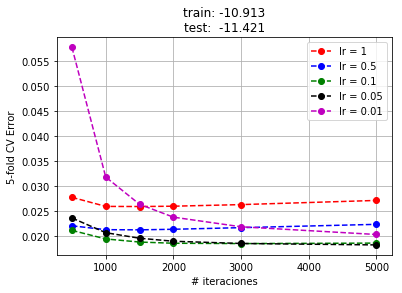

In [153]:
error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations),1)
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(gb.score(X_train,y_train),gb.score(X_test,y_test)))
plt.grid()
plt.show()


In [204]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500,2000,3000,5000,7000]
learningRate = [0.05,0.01]
maxDepth = 3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }


grid = GridSearchCV(GradientBoostingRegressor(random_state=0, 
                                           n_estimators=200, 
                                           max_features='sqrt'), 
                                           param_grid=param_grid,
                                           cv=10,
                                           n_jobs=-1)
grid.fit(X_train_S, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))


best mean cross-validation score: 0.982
best parameters: {'learning_rate': 0.05, 'n_estimators': 5000}


In [205]:
# calculamos métricas globales

learning_rate = grid.best_params_['learning_rate']
n_estimators = grid.best_params_['n_estimators']

gb = GradientBoostingRegressor(random_state=0, max_depth=maxDepth,learning_rate = learning_rate, 
                                n_estimators= n_estimators)
gb.fit(X_train_S,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5000, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

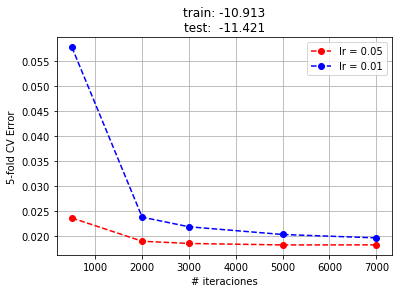

In [206]:
error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations),1)
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(gb.score(X_train,y_train),gb.score(X_test,y_test)))
plt.grid()
plt.show()

Vemos que tenemos unos valores correctos para el modelo y que no se ve que a partir de 5000 los valores no sean estables, con lo que tomamos esos parametros para el modelo.

In [209]:
tuned_parameters = {'learning_rate': 0.05, 'n_estimators': 5000, 'max_depth':3}

maxDepth = tuned_parameters['max_depth']
learning_rate = tuned_parameters['learning_rate']
n_estimators = tuned_parameters['n_estimators']

gb = GradientBoostingRegressor(random_state=0, max_depth=maxDepth,learning_rate = learning_rate, 
                                n_estimators= n_estimators)
gb.fit(X_train_S,y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5000, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [210]:
ytrainGB = gb.predict(X_train_S)
ytestGB  = gb.predict(X_test_S)
    
mseTrain = mean_squared_error(y_train,ytrainGB)
mseTest = mean_squared_error(y_test,ytestGB)
    
r2train = gb.score(X_train_S, y_train)
r2test = gb.score(X_test_S, y_test)
    
resultado = ["Gradient Boosting", tuned_parameters, mseTrain, mseTest, r2train, r2test]
add_row(resultadosModelo, resultado)


,Modelo,parametros-optimos,MSE_train,MSE_test,r2_train,r2_test
0,Gradient Boosting,"{'learning_rate': 0.05, 'n_estimators': 5000, ...",197953.379422,281710.886272,0.987649,0.981734
1,Random Forest Regressor,{'max_depth': 19},61461.593098,305867.683874,0.996165,0.980168
2,Random Forest Regressor,{'max_depth': 18},70515.447067,306043.040073,0.995600,0.980156
3,Random Forest Regressor,{'max_depth': 17},84022.142973,307598.753062,0.994758,0.980055
4,Random Forest Regressor,{'max_depth': 16},101769.518863,305055.845804,0.993650,0.980220
5,Random Forest Regressor,{'max_depth': 15},126907.888306,313972.410209,0.992082,0.979642
6,Random Forest Regressor,{'max_depth': 14},160037.602747,325337.836168,0.990015,0.978905
7,Random Forest Regressor,{'max_depth': 13},199861.192143,341955.582236,0.987530,0.977828
8,Random Forest Regressor,{'max_depth': 12},259324.618384,378399.709323,0.983820,0.975465
9,Random Forest Regressor,{'max_depth': 11},337660.281409,432944.270079,0.978932,0.971928


## 4. Eleccion de Modelo
Hemos entrenado los siguientes modelos:

In [211]:
resultadosModelo

,Modelo,parametros-optimos,MSE_train,MSE_test,r2_train,r2_test
11,Random Forest Regressor,{'max_depth': 9},584656.553925,631767.963437,0.963521,0.959036
10,Random Forest Regressor,{'max_depth': 10},433238.165969,502821.087279,0.972968,0.967397
9,Random Forest Regressor,{'max_depth': 11},337660.281409,432944.270079,0.978932,0.971928
8,Random Forest Regressor,{'max_depth': 12},259324.618384,378399.709323,0.983820,0.975465
7,Random Forest Regressor,{'max_depth': 13},199861.192143,341955.582236,0.987530,0.977828
6,Random Forest Regressor,{'max_depth': 14},160037.602747,325337.836168,0.990015,0.978905
5,Random Forest Regressor,{'max_depth': 15},126907.888306,313972.410209,0.992082,0.979642
4,Random Forest Regressor,{'max_depth': 16},101769.518863,305055.845804,0.993650,0.980220
3,Random Forest Regressor,{'max_depth': 17},84022.142973,307598.753062,0.994758,0.980055
2,Random Forest Regressor,{'max_depth': 18},70515.447067,306043.040073,0.995600,0.980156


Vemos que el modelo que mejor se comporta es `Random Forest` para una `max_depth=19` pero cómo quiero alcanzar un compromiso entre sesgo y varianza, bla,bla....

Así pues elijo `GradientBoostingRegressor` con los siguientes parámetros: `learning_rate = 0.05`, `max_depth = 3` y `n_estimators = 5000`y vuelvo a entrenar el modelo, pero esta vez con todos los datos.

In [212]:
# preparamos los datos
features = data.columns.drop(['price'])
X = data[features].values
y = data['price'].values

# Entrenamos el modelo elegido con todos los datos
# best parameters: {'learning_rate': 0.05, 'n_estimators': 5000}

learning_rate = 0.05
max_depth = 3
n_estimators = 5000

X_S = scaler.transform(X)

modeloElegido = GradientBoostingRegressor(random_state=0, max_depth=max_depth,learning_rate = learning_rate, 
                                n_estimators= n_estimators)
modeloElegido.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5000, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

Y usamos el modelo, para predecir el resultado, después de realizar las transformaciones que aplicamos en un principio al conjunto de entrenamiento.

In [213]:
test_data = pd.read_csv('./data/diamonds_test.csv',sep=',', decimal='.')
test_data.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.55,Very Good,E,SI2,59.6,57.0,5.34,5.39,3.20
1,1,0.35,Ideal,G,SI1,60.6,56.0,4.56,4.58,2.77
2,2,1.53,Good,H,IF,63.1,57.0,7.25,7.34,4.60
3,3,0.52,Ideal,E,VS1,61.8,56.0,5.17,5.19,3.20
4,4,0.54,Ideal,D,SI1,62.6,55.0,5.19,5.23,3.26


In [214]:
# Transformacion de variables
corte = {'Fair': 1,'Good': 2, 'Very Good': 3, 'Premium':4, 'Ideal':5}
color = {'J':1,'I':2,'H':3,'G':4,'F':5,'E':6,'D':7}
claridad = {'I1':1,'SI2':2,'SI1':3,'VS2':4,'VS1':5,'VVS2':6,'VVS1':7,'IF':8}

test_data.cut = [corte[item] for item in test_data.cut] 
test_data.color = [color[item] for item in test_data.color]
test_data.clarity = [claridad[item] for item in test_data.clarity] 

In [215]:
test_data = test_data.drop(["x", "y","z"], axis=1)

In [216]:
test_data.head(2)

,id,carat,cut,color,clarity,depth,table
0,0,0.55,3,6,2,59.6,57.0
1,1,0.35,5,4,3,60.6,56.0


Con todos los datos preparados realizamos la predicción

In [217]:
features = test_data.columns.drop(['id'])
X = test_data[features].values

In [218]:
y_pred = modeloElegido.predict(X)

Incorporamos la predicción al dataframe

In [219]:
test_data['target'] = y_pred

test_data = test_data.drop(["carat",
                            "cut",
                            "color",
                            "clarity",
                            "depth",
                            "table"], axis=1)

Y grabamos los resultados en un archivo

In [220]:
test_data.head()

,id,target
0,0,1242.006317
1,1,633.382565
2,2,12126.048876
3,3,1935.576403
4,4,1608.008914


In [221]:
test_data.to_csv('./data/diamonds_pred.csv',sep=',', decimal='.')